In [1]:
import torchvision
import torch
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from torchvision.models import ResNet18_Weights

In [2]:
train_dataset_path = './monkeys/training/training'
test_dataset_path = './monkeys/validation/validation'

In [3]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2038]


train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform=test_transforms)

In [5]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([2, 6, 4, 3, 2, 5])


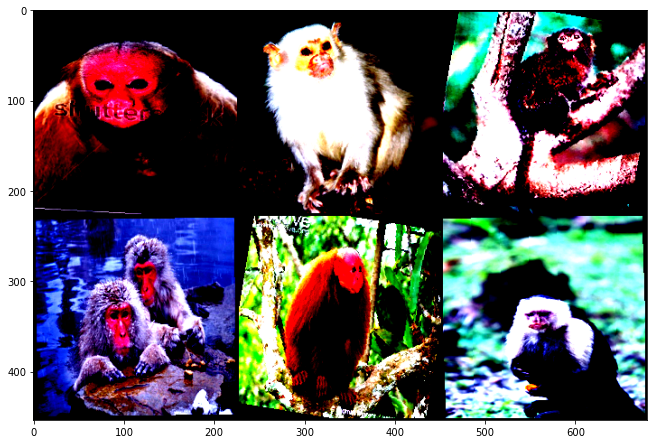

In [6]:
show_transformed_images(train_dataset)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
def set_device():
    if torch.cuda.is_available():
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    return torch.device(dev)

In [9]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()
    
    with torch.no_grad():   # no backpropogate, speeds up, for evaluate
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
            
    epoch_accuracy = 100.00 * predicted_correctly_on_epoch / total
    
    print('   - Test dataset. Got %d out of %d images correctly (%.3f%%).'
             % (predicted_correctly_on_epoch, total, epoch_accuracy))
    
    return epoch_accuracy

In [10]:
def save_checkpoint(model, epoch, optimizer, best_accuracy):
    state = {
        'epoch': epoch + 1,
        'model': model.state_dict(),
        'best accuracy': best_accuracy,
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [17]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_accuracy = 0
    
    for epoch in range(n_epochs):
        print('Epoch Number %d ' % (epoch+1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_accuracy = 100.00 * running_correct / total
        
        print('   - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f'
             % (running_correct, total, epoch_accuracy, epoch_loss))
        
        test_dataset_accuracy = evaluate_model_on_test_set(model, test_loader)
        
        if(test_dataset_accuracy > best_accuracy):
            best_accuracy = test_dataset_accuracy
            save_checkpoint(model, epoch, optimizer, best_accuracy)
        
    print('Finished')
    return model

In [18]:
resnet18_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)   # random weights, untrained option

num_features = resnet18_model.fc.in_features     # temp variable, size of each input sample
number_of_classes = 10                           # categories, the 10 species to classify

resnet18_model.fc = nn.Linear(num_features, number_of_classes) # prepares necessary matrices for forward passses

device = set_device()
resnet18_model = resnet18_model.to(device)

loss_fn = nn.CrossEntropyLoss()                  # shows error during training process

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003) # use stochastic gradient descent
                                                                                              # learning rate is key variable

In [19]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 3)

Epoch Number 1 
   - Training dataset. Got 870 out of 1097 images correctly (79.307%). Epoch loss: 0.639
   - Test dataset. Got 251 out of 272 images correctly (92.279%).
Epoch Number 2 
   - Training dataset. Got 1066 out of 1097 images correctly (97.174%). Epoch loss: 0.114
   - Test dataset. Got 259 out of 272 images correctly (95.221%).
Epoch Number 3 
   - Training dataset. Got 1043 out of 1097 images correctly (95.077%). Epoch loss: 0.132
   - Test dataset. Got 233 out of 272 images correctly (85.662%).
Finished


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')

In [21]:
resnet18_model = models.resnet18()   
num_features = resnet18_model.fc.in_features     
number_of_classes = 10                           
resnet18_model.fc = nn.Linear(num_features, number_of_classes) 

resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, 'best_model.pth')